### Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Original Data - rf_data.csv

In [118]:
gaussian_data_path = '../data/processed/Gaussian_Reduced_Data.csv'

In [119]:
df_gaussian = pd.read_csv(gaussian_data_path)
df_gaussian.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365040 entries, 0 to 365039
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   age_days                  365040 non-null  float64
 1   casing_mileage_kms        365040 non-null  float64
 2   Life_Num                  365040 non-null  float64
 3   wp_load_kg                365040 non-null  float64
 4   avg_veh_speed_kph         365040 non-null  float64
 5   P_avg_bar                 365040 non-null  float64
 6   T_avg_degC                365040 non-null  float64
 7   n_rxns_cumul              365040 non-null  float64
 8   NC_sidewall_SEelm_sumrev  365040 non-null  float64
 9   NC_sidewall_CVMD_AMP      365040 non-null  float64
 10  NC_sidewall_maxCVMD_rev   365040 non-null  float64
 11  predicted_RCP             360864 non-null  float64
 12  Tire_ID                   365040 non-null  object 
dtypes: float64(12), object(1)
memory usage: 36.2

In [120]:
df = df_gaussian[['Tire_ID','age_days','predicted_RCP']]

In [121]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365040 entries, 0 to 365039
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Tire_ID        365040 non-null  object 
 1   age_days       365040 non-null  float64
 2   predicted_RCP  360864 non-null  float64
dtypes: float64(2), object(1)
memory usage: 8.4+ MB


,Tire_ID,age_days,predicted_RCP
0,0916W03,-8.881784e-16,1.0
1,0916W03,7.537879e-01,1.0
2,0916W03,1.507576e+00,1.0
3,0916W03,2.261364e+00,1.0
4,0916W03,3.015152e+00,1.0


In [122]:
null_stats = pd.DataFrame(df.isna().sum(), columns=['Missing Values'])
null_stats['% of Total'] = (null_stats['Missing Values'] / df.shape[0]) * 100
print(null_stats)

               Missing Values  % of Total
Tire_ID                     0    0.000000
age_days                    0    0.000000
predicted_RCP            4176    1.143984


In [123]:
mask = df.isna().any(axis=1)
example_row = df[mask].head(1)
print("Example of a row with a null value:\n", example_row)

Example of a row with a null value:
       Tire_ID      age_days  predicted_RCP
10656  KR9789  2.122746e-13            NaN


In [124]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360864 entries, 0 to 365039
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Tire_ID        360864 non-null  object 
 1   age_days       360864 non-null  float64
 2   predicted_RCP  360864 non-null  float64
dtypes: float64(2), object(1)
memory usage: 11.0+ MB


In [125]:
duplicates = df.duplicated(keep=False)
print(df[duplicates])
print("Total duplicate rows:", duplicates.sum())

Empty DataFrame
Columns: [Tire_ID, age_days, predicted_RCP]
Index: []
Total duplicate rows: 0


In [126]:
invalid = df[(df[['age_days']] < 0.1).all(axis=1)]
invalid.info()
print('Invalid Data:')
invalid.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2506 entries, 0 to 364896
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Tire_ID        2506 non-null   object 
 1   age_days       2506 non-null   float64
 2   predicted_RCP  2506 non-null   float64
dtypes: float64(2), object(1)
memory usage: 78.3+ KB
Invalid Data:


,Tire_ID,age_days,predicted_RCP
0,0916W03,-8.881784e-16,1.0
144,0714T56,-3.463896e-14,1.0
288,MK6870,-9.681145e-14,1.0
432,MK6503,-1.758593e-13,1.0
576,MK7050A,2.087219e-13,1.0


In [127]:
df = df[(df[['age_days']] >= 0.1).all(axis=1)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 358358 entries, 1 to 365039
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Tire_ID        358358 non-null  object 
 1   age_days       358358 non-null  float64
 2   predicted_RCP  358358 non-null  float64
dtypes: float64(2), object(1)
memory usage: 10.9+ MB


In [128]:
df.to_csv('../data/rf_training/rf_data.csv', index=False)

### Simulation Data - simulation_data.csv

In [129]:
# rounding down age_days for easier bucketing during simulation
df['age_days'] = np.floor(df['age_days'])
df.head()

,Tire_ID,age_days,predicted_RCP
1,0916W03,0.0,1.0
2,0916W03,1.0,1.0
3,0916W03,2.0,1.0
4,0916W03,3.0,1.0
5,0916W03,3.0,1.0


In [130]:
max_age_by_tire = df.groupby('Tire_ID')['age_days'].max().reset_index()
max_age_by_tire.columns = ['Tire_ID', 'max_age_days']
print(max_age_by_tire.head())

   Tire_ID  max_age_days
0  0215T01        1568.0
1  0215T02        1653.0
2  0215T03        1183.0
3  0215T04         318.0
4  0215T06        1684.0


In [131]:
rcp_filtered_df = df[df['predicted_RCP'] > 0]
max_age_tire = rcp_filtered_df[rcp_filtered_df['age_days'] == rcp_filtered_df['age_days'].max()]
print(max_age_tire)

       Tire_ID  age_days  predicted_RCP
95459    AM167    1967.0       0.001755
173363   AM333    1967.0       0.000687


In [132]:
df['age_days'].max()

2999.0

In [133]:
df = df[df['age_days'] <= 2000]
df.info()
df['age_days'].max()

<class 'pandas.core.frame.DataFrame'>
Index: 356753 entries, 1 to 365039
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Tire_ID        356753 non-null  object 
 1   age_days       356753 non-null  float64
 2   predicted_RCP  356753 non-null  float64
dtypes: float64(2), object(1)
memory usage: 10.9+ MB


2000.0

In [147]:
df.to_csv('../data/rf_training/simulation_data.csv', index=False)

### Tire ID Data - tire_data.csv

In [134]:
df['Tire_ID'].nunique()

2506

In [141]:
df_tireid = rcp_filtered_df.groupby('Tire_ID')['age_days'].max().reset_index()
df_tireid.columns = ['Tire_ID', 'max_age_days']
df_tireid.info()
df_tireid.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2506 entries, 0 to 2505
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Tire_ID       2506 non-null   object 
 1   max_age_days  2506 non-null   float64
dtypes: float64(1), object(1)
memory usage: 39.3+ KB


,Tire_ID,max_age_days
0,0215T01,575.0
1,0215T02,457.0
2,0215T03,755.0
3,0215T04,233.0
4,0215T06,770.0


In [142]:
df_tireid = df_tireid.drop_duplicates().sort_values(by='Tire_ID')
df_tireid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2506 entries, 0 to 2505
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Tire_ID       2506 non-null   object 
 1   max_age_days  2506 non-null   float64
dtypes: float64(1), object(1)
memory usage: 39.3+ KB


In [143]:
bins = [0, 400, 800, 1200, 1600, 2000]
labels = ['0-399', '400-799', '800-1199', '1200-1599', '1600-1999']
df_tireid['age_category'] = pd.cut(df_tireid['max_age_days'], bins=bins, labels=labels, include_lowest=True)
age_distribution = df_tireid['age_category'].value_counts().sort_index()

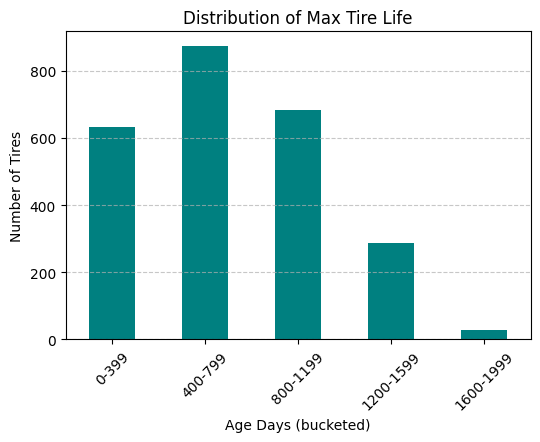

age_category
0-399        634
400-799      874
800-1199     683
1200-1599    286
1600-1999     29
Name: count, dtype: int64


In [145]:
# Plotting
plt.figure(figsize=(6, 4))
age_distribution.plot(kind='bar', color='teal')
plt.title('Distribution of Max Tire Life')
plt.xlabel('Age Days (bucketed)')
plt.ylabel('Number of Tires')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
print(age_distribution)

In [146]:
df_tireid.to_csv('../data/rf_training/tire_data.csv', index=False)

### Simulation Episodes - simulation_episode.csv

In [3]:
simulation_df = pd.read_csv('../data/rf_training/simulation_data.csv')
simulation_df.head()

,Tire_ID,age_days,predicted_RCP
0,0916W03,0.0,1.0
1,0916W03,1.0,1.0
2,0916W03,2.0,1.0
3,0916W03,3.0,1.0
4,0916W03,3.0,1.0


In [4]:
# Create checkpoints from 30 to 2000 in steps of 30
check_points = np.arange(0, 2001, 30)

# Create a new DataFrame to store the results
episodes_df = pd.DataFrame({'Tire_ID': pd.Series(dtype='object'), 'check_point': pd.Series(dtype='int'), 'MappedRCP': pd.Series(dtype='float')})

In [5]:
new_data = []

# Process each unique tire
for tire_id in simulation_df['Tire_ID'].unique():
    tire_data = simulation_df[simulation_df['Tire_ID'] == tire_id]
    
    # For each checkpoint, find the closest 'Age_days' and get its 'PredictedRCP'
    for check_point in check_points:
        # Find the closest 'Age_days'
        closest_age_day = tire_data.iloc[(tire_data['age_days'] - check_point).abs().argsort()[:1]]
        # Append the results to a list
        new_data.append({
            'Tire_ID': tire_id,
            'check_point': check_point,
            'MappedRCP': closest_age_day['predicted_RCP'].values[0]
        })
episodes_df = pd.DataFrame(new_data)


In [6]:
episodes_df.head()

,Tire_ID,check_point,MappedRCP
0,0916W03,0,1.0
1,0916W03,30,1.0
2,0916W03,60,1.0
3,0916W03,90,1.0
4,0916W03,120,1.0


In [8]:
episodes_df.to_csv('../data/rf_training/simulation_episodes.csv', index=False)

In [9]:
episodes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167902 entries, 0 to 167901
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Tire_ID      167902 non-null  object 
 1   check_point  167902 non-null  int64  
 2   MappedRCP    167902 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 3.8+ MB


In [10]:
print("Count of Episodes: ", episodes_df['check_point'].nunique())

Count of Episodes:  67


In [25]:
df_tire = pd.read_csv('../data/rf_training/tire_data.csv')
df_tire.head()

,Tire_ID,age_category
0,KH6427A,0-399
1,STX04,0-399
2,STX03,0-399
3,STO05,0-399
4,DC4452,0-399


In [26]:
rcp_zero_df = episodes_df[episodes_df['MappedRCP'] == 0]

# If there are multiple zeros, take the first occurrence
rcp_zero_df = rcp_zero_df.groupby('Tire_ID').first().reset_index()

In [27]:
df_tire = pd.merge(df_tire, rcp_zero_df[['Tire_ID', 'check_point']], on='Tire_ID', how='left')
df_tire.rename(columns={'check_point': 'check_point_zero'}, inplace=True)

In [28]:
df_tire.head()

,Tire_ID,age_category,check_point_zero
0,KH6427A,0-399,90.0
1,STX04,0-399,120.0
2,STX03,0-399,120.0
3,STO05,0-399,120.0
4,DC4452,0-399,150.0


In [29]:
df_tire_sorted = df_tire.sort_values(by='check_point_zero')
df_tire_sorted.head()

,Tire_ID,age_category,check_point_zero
0,KH6427A,0-399,90.0
1,STX04,0-399,120.0
2,STX03,0-399,120.0
3,STO05,0-399,120.0
11,JH1819W,0-399,150.0


In [30]:
df_tire_sorted.to_csv('../data/rf_training/tire_data.csv', index=False)